# Generative Cooperative Networks (GCNs)

This notebook contains a custom architecture (GCNs) and a training loop on the CIFAR-10 dataset. Instead of relying on the typical adversarial objectives, GCNs focus on **joint representation learning**

In this setup:
- The **generator's** main task is to reconstruct a masked image
- The **discriminator**, on the other hand, works to predict the mask from the reconstructed image

A unique characteristic that sets GCNs apart is the shift from the standard *sample-wise* discrimination found in GANs, to a granular pixel-wise discrimination


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/johanhagner/Generative-Colaboratory-Networks/blob/main/gcn.ipynb)

In [ ]:
# Install libraries
!pip install -q keras-core
!pip install -q jax jaxlib

In [ ]:
# Import libraries
import os
os.environ["KERAS_BACKEND"] = "jax"
import keras_core as keras

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import time

from google.colab import drive
from jax import devices
from keras.datasets import cifar10
from keras.layers import Input, Conv2D, Flatten, Dense, Concatenate
from keras.losses import mean_squared_error
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.utils import to_categorical
from tqdm.notebook import tqdm

# Mount Google Drive
drive.mount('/content/drive')

# print(devices()) # See if GPU is used

Using JAX backend.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cifar10_class_names = [ "airplane", "automobile", "bird", "cat", "deer",
                       "dog", "frog", "horse", "ship", "truck" ]

# Download and split the dataset
(x_train, y_train_original), (x_test, y_test_original) = cifar10.load_data()

# Normalize the data for better training performance
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encode the labels
y_train_encoded = to_categorical(y_train_original, num_classes=10)
y_test_encoded = to_categorical(y_test_original, num_classes=10)

In [ ]:
def mask(data, seed=42, mask_fraction=0.35):
    # Extract the dimensions
    data_size, height, width, channels = data.shape

    # Generate mask with random values between 0 and 1 over the entire data
    np.random.seed(seed)
    mask = np.random.rand(data_size, height, width, 1)
    mask = np.where(mask < mask_fraction, 0, 1)  # Values below the threshold are set to 0
    mask_repeated = np.repeat(mask, channels, axis=3)
    masked_data = data * mask_repeated

    return mask, masked_data

def combine_real_and_generated(imgs, rc_imgs, masks):
    # Combine to real and reconstructed images with help of masks
    gen_masked_pixels = rc_imgs * (1 - masks)
    real_unmasked_pixels = imgs * masks
    mixed_imgs = gen_masked_pixels + real_unmasked_pixels

    return mixed_imgs

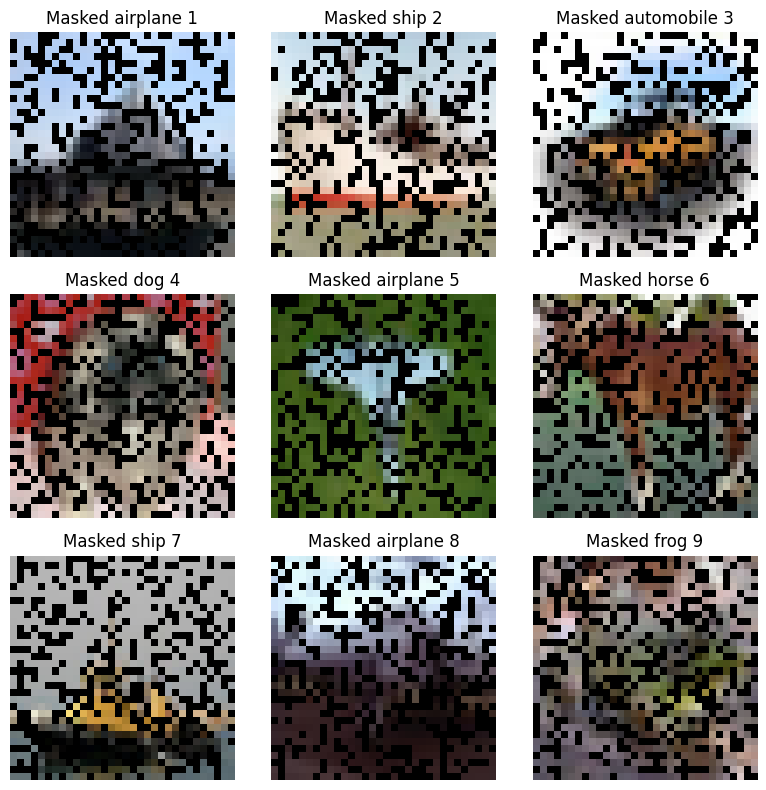

In [ ]:
current_time = int(time.time())
np.random.seed(current_time)

random_indices = np.random.choice(x_train.shape[0], 128, replace=False)
sample_batch = x_train[random_indices]
sample_labels = y_train_original[random_indices]

sample_mask, sample_x_masked = mask(sample_batch)

# Display some masked images their labels
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
for i in range(3):
    label_int = sample_labels[i][0]
    string_label = cifar10_class_names[label_int]

    axs[0, i].imshow(sample_x_masked[i, :, :, :])
    axs[0, i].axis('off')
    axs[0, i].set_title(f"Masked {string_label} {i+1}")

for i in range(3):
    label_int = sample_labels[i+3][0]
    string_label = cifar10_class_names[label_int]

    axs[1, i].imshow(sample_x_masked[i + 3, :, :, :])
    axs[1, i].axis('off')
    axs[1, i].set_title(f"Masked {string_label} {i+4}")

for i in range(3):
    label_int = sample_labels[i+6][0]
    string_label = cifar10_class_names[label_int]

    axs[2, i].imshow(sample_x_masked[i + 6, :, :, :])
    axs[2, i].axis('off')
    axs[2, i].set_title(f"Masked {string_label} {i+7}")

plt.tight_layout()
plt.show()

In [ ]:
# Create shared convolutional layers
def create_shared_layers(num_layers=2):
    shared_layers = []

    # Generate filter depths dynamically based on num_layers
    filter_depths = [32 * (2**i) for i in range(num_layers)]
    for i in range(num_layers):
        shared_layers.append(Conv2D(filter_depths[i], (3,3), activation='relu', padding='same'))

    return shared_layers

# Build the generator model using shared layers
def build_generator(shared_layers, input_shape=(32,32,4)):
    input_layer = Input(shape=input_shape, name="generator_input")
    image, mask = input_layer[:,:,:,:3], input_layer[:,:,:,3:]

    x = shared_layers[0](image)
    for layer in shared_layers[1:-1]:
        x = layer(x)

    x = Concatenate(axis=-1)([x, mask])
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = shared_layers[-1](x)

    output = Conv2D(3, (3,3), activation='sigmoid', padding='same', name="generator_output")(x)
    return Model(inputs=input_layer, outputs=output, name="generator")

# Build the discriminator model using shared layers
def build_discriminator(shared_layers, input_shape=(32,32,3)):
    input_layer = Input(shape=input_shape, name="discriminator_input")

    x = input_layer
    for layer in shared_layers:
        x = layer(x)

    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    output = Conv2D(1, (3,3), activation='linear', padding='same', name="discriminator_output")(x)

    return Model(inputs=input_layer, outputs=output, name="discriminator")

# Build a temporary classifier using shared layers
def build_temp_classifier(shared_layers, num_classes=10, input_shape=(32,32,3)):
    input_layer = Input(shape=input_shape, name="temp_classifier_input")

    x = input_layer
    for layer in shared_layers:
        x = layer(x)

    x = Flatten()(x)
    output = Dense(num_classes, activation='softmax', name="temp_classifier_output")(x)

    return Model(inputs=input_layer, outputs=output, name="temp_classifier")

# Create shared layers
shared_layers = create_shared_layers()

# Create generator, discriminator, and temporary classifier models
generator = build_generator(shared_layers)
discriminator = build_discriminator(shared_layers)
temp_classifier = build_temp_classifier(shared_layers)

In [ ]:
save_directory = "/content/drive/MyDrive/hydra"

# Create the directory if it doesn't exist
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

def load_model(model, checkpoint):
    model_save_path = os.path.join(save_directory, checkpoint)
    if model and os.path.exists(model_save_path):
        print(f"Loading checkpoint for: {checkpoint}")
        model.load_weights(model_save_path)

def load_models():
    load_model(generator, "generator_weights.h5")
    load_model(discriminator, "discriminator_weights.h5")
    load_model(temp_classifier, "temp_classifier_weights.h5")

def save_model(model, checkpoint):
    if model:
        model_save_path = os.path.join(save_directory, checkpoint)
        model.save_weights(model_save_path)

def save_models():
    print(f"Saving checkpoints")
    save_model(generator, 'generator_weights.h5')
    save_model(discriminator, 'discriminator_weights.h5')
    save_model(temp_classifier, 'temp_classifier_weights.h5')

def freeze_layers(layers):
    for layer in layers:
        layer.trainable = False

def unfreeze_layers(layers):
    for layer in layers:
        layer.trainable = True

In [ ]:
def pretrain(epochs=10, batch_size=256, d_lr=0.0002, g_lr=0.00003, c_lr=0.0002, beta=0.5):
    # Load checkpoints if available
    load_models()

    # Compile models
    discriminator.compile(loss='mse', optimizer=Adam(d_lr, beta))
    generator.compile(loss='mse', optimizer=Adam(g_lr, beta))
    temp_classifier.compile(loss='categorical_crossentropy', optimizer=Adam(c_lr, beta), metrics=['accuracy'])

    for epoch in range(epochs):
        # Re-mask the training and test set with unique masks
        current_time = int(time.time())
        train_masks, x_train_masked = mask(x_train, current_time)
        test_masks, x_test_masked = mask(x_test, current_time + 1)

        batch_progress = tqdm(range(0, len(x_train), batch_size), desc=f"Epoch {epoch + 1} Progress", position=1, leave=False)

        for batch_idx in batch_progress:
            end_idx = batch_idx + batch_size
            if end_idx > x_train.shape[0]:
                end_idx = x_train.shape[0]

            imgs, masked_imgs, masks = x_train[batch_idx:end_idx], x_train_masked[batch_idx:end_idx], train_masks[batch_idx:end_idx]
            gen_input_data = np.concatenate([masked_imgs, masks], axis=-1)
            rc_imgs = generator.predict(gen_input_data, verbose=0)
            mixed_imgs = combine_real_and_generated(imgs, rc_imgs, masks)

            d_loss = discriminator.train_on_batch(mixed_imgs, masks)
            g_loss = generator.train_on_batch(gen_input_data, imgs)

            # Do not train the backbone on the the classifier trask during pretraining
            freeze_layers(shared_layers)
            c_loss = temp_classifier.train_on_batch(imgs, y_train_encoded[batch_idx:end_idx])
            unfreeze_layers(shared_layers)

            batch_progress.set_description(f"Epoch {epoch + 1} Progress (Class Train Acc: {c_loss[1]*100:.2f}, Disc Train Loss: {d_loss:.4f}, Gen Train Loss: {g_loss:.4f}%)")

        test_input_data = np.concatenate([x_test_masked, test_masks], axis=-1)
        test_rc_imgs = generator.predict(test_input_data, verbose=0)
        test_mixed_imgs = combine_real_and_generated(x_test, test_rc_imgs, test_masks)
        test_pred_masks = discriminator.predict(test_mixed_imgs, verbose=0)

        g_test_loss = np.mean(np.square(test_rc_imgs - x_test))
        d_test_loss = np.mean(np.square(test_pred_masks - test_masks))
        c_eval = temp_classifier.evaluate(x_test, y_test_encoded, verbose=0)

        print(f"[Epoch {epoch+1}/{epochs}] [Class Test Acc: {c_eval[1]:.4f}, Disc Test Loss: {d_test_loss:.4f}, Gen Test Loss: {g_test_loss:.4f}]")

    # Save checkpoints
    save_models()

    return x_test_masked, test_mixed_imgs, test_masks, test_pred_masks

In [ ]:
# Pretrain the networks, get data from evaluation to visualize below
x_test_masked, test_mixed_imgs, test_masks, test_pred_masks = pretrain(epochs=5)

Epoch 1 Progress:   0%|          | 0/196 [00:00<?, ?it/s]

[Epoch 1/1] [Class Test Acc: 0.4546, Disc Test Loss: 0.1344, Gen Test Loss: 0.0192]
Saving checkpoints


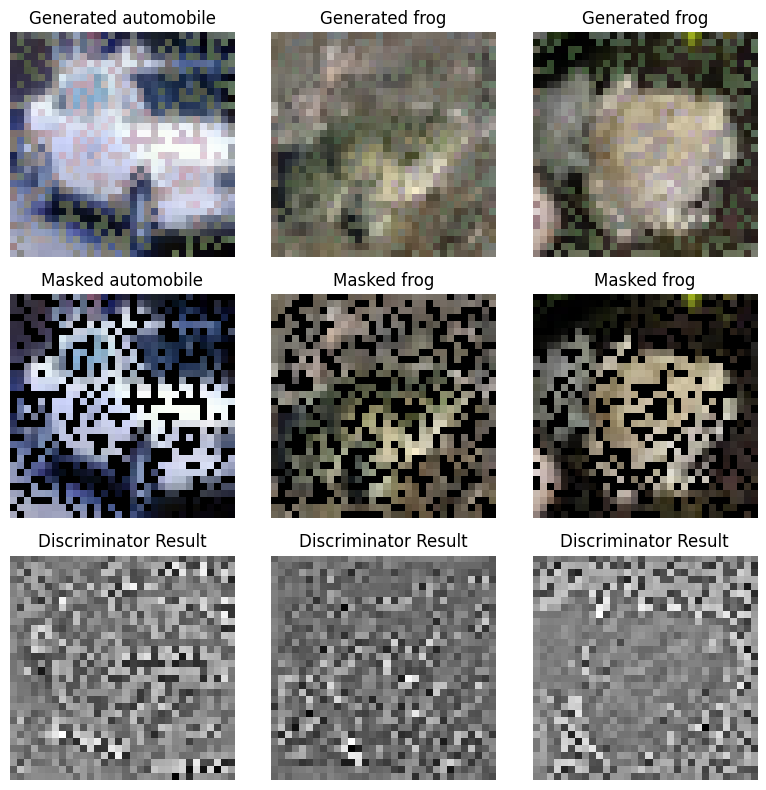

In [ ]:
# Print some example images to monitor progress
def plot_collage(x_test_masked, test_mixed_imgs, test_masks, test_pred_masks, threshold=0.5):

    indices = np.random.choice(x_test_masked.shape[0], 3, replace=False)

    fig, axs = plt.subplots(3, 3, figsize=(8, 8))

    for i, idx in enumerate(indices):
        label_int = y_test_original[idx][0]
        string_label = cifar10_class_names[label_int]

        axs[0, i].imshow(test_mixed_imgs[idx])
        axs[0, i].axis('off')
        axs[0, i].set_title(f"Generated {string_label}")

        axs[1, i].imshow(x_test_masked[idx])
        axs[1, i].axis('off')
        axs[1, i].set_title(f"Masked {string_label}")

        axs[2, i].imshow(test_pred_masks[idx], cmap='gray')
        axs[2, i].axis('off')
        axs[2, i].set_title(f"Discriminator Result")

    plt.tight_layout()
    plt.show()

plot_collage(x_test_masked, test_mixed_imgs, test_masks, test_pred_masks)